<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Sentiment_BERT_ORI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Sentiment Classification

The Google AI team published a paper in 2018 titled [Bidirectional Encoder Representations from Transformers for Natural Language Understanding](https://arxiv.org/abs/1810.04805), or more simply, BERT. This model is trained a large corpus of natural language text using in a self-supervised learning style. During training, the model is tries to predict a small set of masked words in a sentence.

Consider this sentence: "It's raining outside, unfortunately I left my _________ at home". Clearly, the missing word should be umbrella, or similar. The missing word can be determined from context found in surrounding words. BERT learns context by "reading" millions of sentences, producing a pre-trained model that understands context. Layers can be added on top of pre-trained BERT models for specific language tasks. The complete model can be more accurate due to [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning).

Pre-trained BERT models are available for public use. The example below demonstrates how a simple classification model with a modest training data set can achieve high accuracy by taking advantage of knowledge BERT has previously learned.

In [1]:
%tensorflow_version 2.x

In [2]:
!pip install --quiet bert-for-tf2
!pip install --quiet sentencepiece

     |████████████████████████████████| 40kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 4.6MB/s 


In [3]:
import tensorflow_hub as hub
import bert
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random

# Training Data

Download labeled data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [4]:
# Download data from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

!wget --quiet "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip"
!unzip -q "sentiment labelled sentences"
!mv "sentiment labelled sentences" data
!ls -l data

total 208
-rw-r--r-- 1 root root 58226 Jul  5  2016 amazon_cells_labelled.txt
-rw-r--r-- 1 root root 85285 Feb 15  2015 imdb_labelled.txt
-rw-r--r-- 1 root root  1070 May 31  2015 readme.txt
-rw-r--r-- 1 root root 61320 Jul  5  2016 yelp_labelled.txt


In [70]:
files = ['data/yelp_labelled.txt', 'data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

data = pd.concat(df_list)
data['length'] = data.comment.str.split(' ').str.len()

max_seq_length = 200

# Keep only short comments
shortComments = data[data.length < max_seq_length-5]
print('Number of rows: %d' % len(shortComments))

shortComments.head()

Number of rows: 2743


,comment,sentiment,length
0,Wow... Loved this place.,1,4
1,Crust is not good.,0,4
2,Not tasty and the texture was just nasty.,0,8
3,Stopped by during the late May bank holiday of...,1,15
4,The selection on the menu was great and so wer...,1,12


# Data Preparation

In [71]:
TRAIN = 2330 
TEST = 2743
comments = shortComments.comment.astype(str).tolist()
sentiments = shortComments.sentiment.tolist()
labels = np.asarray(sentiments)

x_train = comments[0:TRAIN]
y_train = labels[0:TRAIN]
x_test = comments[TRAIN:TEST]
y_test = labels[TRAIN:TEST]

In [72]:
print(x_train[0])
print(x_test[0])

Wow... Loved this place.
steve martin delivers a really funny performance of a middle-aged, upper class, uptight white guy.  


In [73]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(bert_path, trainable=False, name='BERT')
vocab_file1 = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file1, do_lower_case=True)

In [74]:
def encodeText(textList):
  token_list = []
  att_list = []
  segment_list = []
  for text in textList:
    tokens = tokenizer.tokenize(text)
    padding = ['[PAD]'] * (max_seq_length - len(tokens) - 2)
    token_ids = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'] + padding)
    token_list.append(token_ids)

    att_mask = [int(id > 0) for id in token_ids]
    att_list.append(att_mask)

    segment_ids = [0]*max_seq_length
    segment_list.append(segment_ids)
  return [tf.cast(token_list,tf.int32), tf.cast(att_list,tf.int32), tf.cast(segment_list,tf.int32)]

In [75]:
print(x_train[0])
encodeText([x_train[0]])

Wow... Loved this place.


[<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
 array([[  101, 10166,  1012,  1012,  1012,  3866,  2023,  2173,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

In [22]:
print(x_test[0])
encodeText([x_test[0]])

steve martin delivers a really funny performance of a middle-aged, upper class, uptight white guy.  


[<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[  101,  3889,  3235, 18058,  1037,  2428,  6057,  2836,  1997,
          1037,  2690,  1011,  4793,  1010,  3356,  2465,  1010,  2039,
         26143,  2317,  3124,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

# Define Model

In [76]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
sortie_BERT = bert_layer([input_word_ids, input_mask, input_segment_ids])

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

model_output_seq = Model([input_word_ids, input_mask, input_segment_ids], sequence_output)
model_output_seq.summary()

model_output_pooled = Model([input_word_ids, input_mask, input_segment_ids], pooled_output)
model_output_pooled.summary()


Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]     

In [68]:
sortie_BERT

[<tf.Tensor 'BERT/StatefulPartitionedCall_5:0' shape=(None, 768) dtype=float32>,
 <tf.Tensor 'BERT/StatefulPartitionedCall_5:1' shape=(None, None, 768) dtype=float32>]

In [77]:
pooled_output

<tf.Tensor 'BERT/StatefulPartitionedCall_8:0' shape=(None, 768) dtype=float32>

In [78]:
sequence_output

<tf.Tensor 'BERT/StatefulPartitionedCall_8:1' shape=(None, None, 768) dtype=float32>

In [85]:
encodeText([x_train[0]])[0]

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[  101, 10166,  1012,  1012,  1012,  3866,  2023,  2173,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [79]:
sortie_prolongation_lexicale_seq = model_output_seq.predict(encodeText([x_train[0]]),verbose=1)
sortie_prolongation_lexicale_pool = model_output_pooled.predict(encodeText([x_train[0]]),verbose=1)

#print("Commentaire :", commentaires[0])
#print("input_ids", output_tokenizer_entrainement['input_ids'][0])
#print("Sortie BERT", sortie_prolongation_lexicale[0])

1/1 [==============================] - 0s 20ms/step


In [80]:
print(sortie_prolongation_lexicale_seq.shape)
print(sortie_prolongation_lexicale_seq)

# Vecteur du premier mot [CLS]
#print(sortie_prolongation_lexicale_seq[:,0,:])

(1, 200, 768)
[[[ 0.33290103  0.14403981  0.15734318 ... -0.31091207  0.3727808
   -0.01420402]
  [ 1.1750797   0.33402944  0.13157754 ... -0.06376196  1.2347517
   -0.69797796]
  [ 0.27667293 -0.91083205  0.70141786 ...  0.45738718  1.2518204
   -0.79927874]
  ...
  [ 0.16696827  0.04958361  0.5952973  ... -0.23928262  0.34050697
   -0.2534288 ]
  [ 0.12017815  0.02416777  0.43853474 ... -0.33656028  0.19453433
   -0.10725914]
  [ 0.23291521 -0.15911546  0.50661075 ... -0.15655492  0.23682216
   -0.48425522]]]


In [42]:
print(sortie_prolongation_lexicale_pool.shape)
sortie_prolongation_lexicale_pool

(1, 768)


array([[-8.61744046e-01, -3.43323708e-01, -8.81922543e-01,
         7.22717524e-01,  6.61231995e-01, -2.18384013e-01,
         9.08083797e-01,  2.20222339e-01, -8.41560125e-01,
        -9.99962509e-01, -4.25652921e-01,  9.05785799e-01,
         9.73826528e-01,  4.53288466e-01,  9.43988979e-01,
        -7.06010461e-01, -2.12116122e-01, -5.79297543e-01,
         3.10203195e-01, -4.88268346e-01,  7.23718286e-01,
         9.99957383e-01,  1.20174952e-01,  3.07119966e-01,
         4.70252693e-01,  9.77804363e-01, -7.38498688e-01,
         9.37963009e-01,  9.39454675e-01,  6.85649812e-01,
        -7.12499797e-01,  1.34492368e-01, -9.86814201e-01,
        -1.97977021e-01, -8.81141543e-01, -9.84222770e-01,
         3.37755978e-01, -6.58392429e-01,  7.63365179e-02,
         6.93049952e-02, -9.10925388e-01,  2.50340611e-01,
         9.99914646e-01, -4.03407872e-01,  2.65088588e-01,
        -3.39293897e-01, -9.99999762e-01,  2.67958671e-01,
        -8.61242890e-01,  8.84906709e-01,  8.00273418e-0

In [23]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

l1 = Lambda(lambda seq: seq[:, 0, :])(sequence_output)
output = Dense(2, activation='softmax')(l1)
model = Model([input_word_ids, input_mask, input_segment_ids], output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

NameError: ignored

# Transfer Learning

BERT layer weights/biases are frozen, only train the final dense layer.

In [ ]:
history = model.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 36s 49ms/step - loss: 0.3773 - accuracy: 0.8496 - val_loss: 0.2810 - val_accuracy: 0.8907
Epoch 2/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2417 - accuracy: 0.9139 - val_loss: 0.2540 - val_accuracy: 0.8889
Epoch 3/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2150 - accuracy: 0.9248 - val_loss: 0.2608 - val_accuracy: 0.8871
Epoch 4/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2016 - accuracy: 0.9216 - val_loss: 0.2531 - val_accuracy: 0.9035
Epoch 5/5
732/732 [==============================] - 34s 47ms/step - loss: 0.1913 - accuracy: 0.9294 - val_loss: 0.2463 - val_accuracy: 0.8998


# Fine Tuning

Unfreeze BERT layer, choose lower learning rate and retrain all layers.

In [ ]:
bert_layer.trainable = True
output.trainable = False
model2 = Model([input_word_ids, input_mask, input_segment_ids], output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
history2 = model2.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 111s 151ms/step - loss: 0.1961 - accuracy: 0.9275 - val_loss: 0.1467 - val_accuracy: 0.9472
Epoch 2/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.2696 - val_accuracy: 0.9381
Epoch 3/5
732/732 [==============================] - 110s 150ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.2351 - val_accuracy: 0.9344
Epoch 4/5
732/732 [==============================] - 110s 150ms/step - loss: 7.8046e-04 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9472
Epoch 5/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0125 - accuracy: 0.9986 - val_loss: 0.2628 - val_accuracy: 0.9399


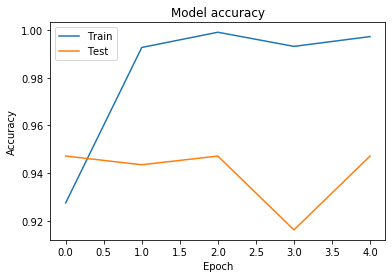

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [ ]:
predictions = model2.predict(encodeText(x_test))
most_likely = predictions.argmax(1)

In [ ]:
index = random.randrange(len(predictions))
print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

I really loved the story line and the poler bear was kinda cute.But if anyone has a question about Fort Steele, just ask away:)  
Prediction: 1, label: 1


# Error Analysis

The Veggitarian platter is out of this world!
Prediction: 0, label: 1


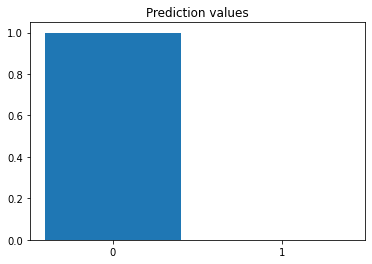

In [ ]:
for i in range(1000):
    index = random.randrange(len(predictions))
    if most_likely[index] != y_test[index]:
        break

print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

plt.bar(range(2), predictions[index], tick_label=range(2))
plt.title('Prediction values')
plt.show()

In [ ]:
text = []
labels = []
preds = []
for i in range(len(predictions)):
  if most_likely[i] != y_test[i]:
    text.append(x_test[i])
    labels.append(y_test[i])
    preds.append(most_likely[i])

errors = pd.DataFrame({'Comment':text, 'Sentiment':labels, 'Predictions':preds})
errors.head()

,Comment,Sentiment,Predictions
0,It definitely was not as good as my S11.,1,0
1,For a product that costs as much as this one d...,0,1
2,You get extra minutes so that you can carry ou...,1,0
3,This place deserves one star and 90% has to do...,0,1
4,I'm not really sure how Joey's was voted best ...,0,1
